In [1]:
import pandas as pd 
from scipy.signal import correlate
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tslearn.clustering import KShape
from tslearn.clustering import TimeSeriesKMeans

import sys
import os
data_path = os.path.abspath('../data')
sys.path.append(data_path)

models_path = os.path.abspath('../models')
sys.path.append(models_path)

import correlations

from sklearn.cluster import KMeans
import scipy.stats


### Loading data 

`voting_data_merged:` Voting trends for election years 2004-2016. Each year comprises of percentage of votes for democrates/republicans for 3 different age groups: 18-29, 30-44, 45-65.

In [2]:
path_data = "/Users/sarazatezalo/Documents/EPFL/semester 3/ada-2024-project-adavengers/"
voting_data_merged = correlations.merge_voting_by_years(path_data)

### Interpolating data for voting 

Since we have available only the voting data for election years, in order to have more fine-grained data, we interpolate the voting trends for the years in between, to obtain the trends for each year 2004-2016.

In [8]:
interpolate_data = correlations.interpolate_votes(voting_data_merged)

### Clustering on original voting data

Clustering states based on their voting trends throughout the election years.

In [5]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(voting_data_merged)
states = voting_data_merged.index
cluster_labels = kmeans.labels_
state_clusters = dict(zip(states, cluster_labels))
print(state_clusters)

{'New York': 2, 'California': 2, 'New Hampshire': 0, 'Wisconsin': 0, 'Iowa': 0, 'Nevada': 0, 'Pennsylvania': 0, 'Virginia': 0, 'Ohio': 0, 'Florida': 0, 'North Carolina': 2, 'Arizona': 0, 'Indiana': 1, 'Georgia': 1, 'South Carolina': 1, 'Kentucky': 1, 'Texas': 1}


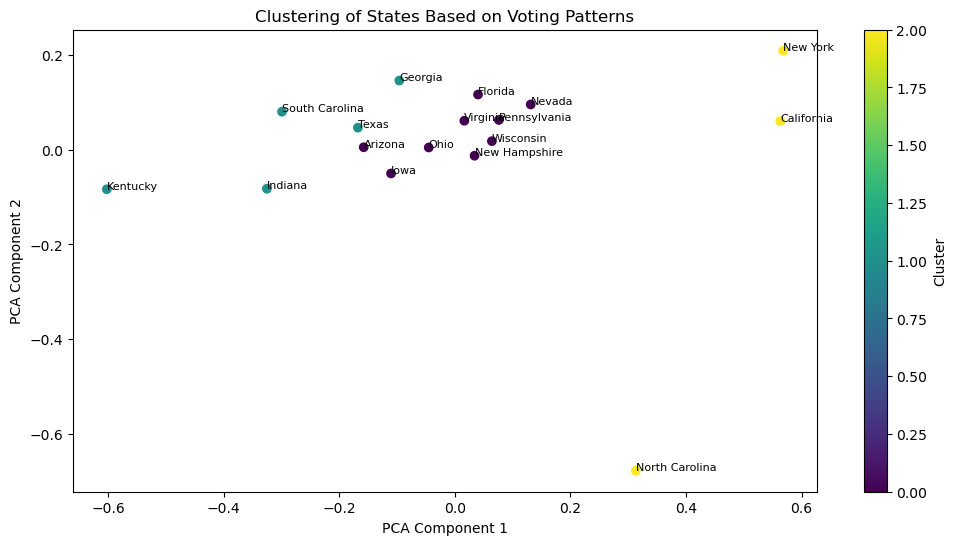

In [6]:
# Visualization of clustering on a lower dimension
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(voting_data_merged)

plt.figure(figsize=(12,6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis')
for i, state in enumerate(states):
    plt.text(reduced_data[i, 0], reduced_data[i, 1], state, fontsize=8)
plt.title("Clustering of States Based on Voting Patterns")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

### Performing clustering on interpolated data

First, we need to prepare the data for time-series clustering. We are trying a few different clustering methods: 
- K-Shape
- K-Means
- Time Series K-Means using Dynamic Time Warping metric

In [7]:
# Drop all columns containing 'republican' in their names since they don't add more information 
interpolate_data_filt = interpolate_data.loc[:, ~interpolate_data.columns.str.contains('republican')]

# This leaves us with 17x39 dataframe: For each state we have a time series for 13 years for 3 different age groups

# Apply K-Shape
kshape = KShape(n_clusters=3, random_state=42)
kshape_labels = kshape.fit_predict(interpolate_data_filt)  
print("Cluster Labels K-Shape:", kshape_labels)

# Apply K-Means 
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(interpolate_data_filt)
states = interpolate_data_filt.index
kmeans_labels = kmeans.labels_
state_clusters = dict(zip(states, kmeans_labels))
print("Cluster Labels K-Means:", kmeans_labels)

# Apply Multivariate DTW-based clustering
tskmeans = TimeSeriesKMeans(n_clusters=3, metric="dtw", n_jobs=-1, random_state=42)
tskmeans_labels = tskmeans.fit_predict(interpolate_data_filt)  
state_clusters = dict(zip(states, tskmeans_labels))
print("Cluster Labels Time Series K-Means:", tskmeans_labels)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Cluster Labels K-Shape: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Cluster Labels K-Means: [2 2 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
Cluster Labels Time Series K-Means: [0 0 0 0 0 0 0 0 0 0 2 0 1 0 1 1 1]


### For further analysis we choose to proceed with results from K-Means

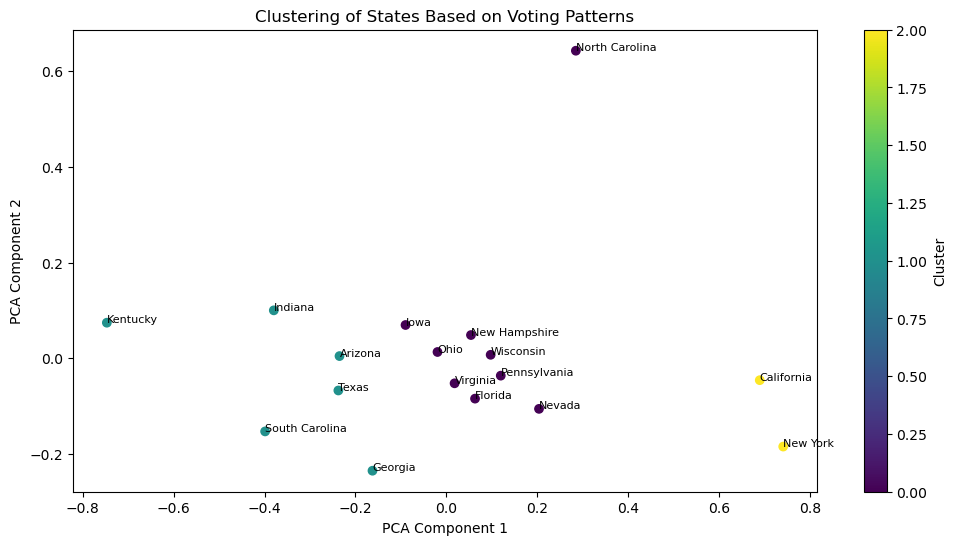

In [8]:
# Visualization of clustering on a lower dimension
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(interpolate_data_filt)

plt.figure(figsize=(12,6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='viridis')
for i, state in enumerate(states):
    plt.text(reduced_data[i, 0], reduced_data[i, 1], state, fontsize=8)
plt.title("Clustering of States Based on Voting Patterns")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

### Plotting the voting trends throughout the years

In [3]:
years = range(2004,2017)
election_years = [2004, 2008, 2012, 2016]
age_groups = ["18_29", "30_44", "45_64"]

### For election years

In [5]:
correlations.plot_vote_distribution(voting_data_merged, age_groups, election_years)

### For all the years (interpolated data)

In [9]:
correlations.plot_vote_distribution(interpolate_data, age_groups, years)